<a href="https://colab.research.google.com/github/neneeeee/entrance-exam-2022/blob/main/dl_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, gc
import pandas as pd
import numpy as np
from hyperopt import hp, fmin, tpe, Trials
from hyperopt.pyll.base import scope
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from joblib import dump, load
import datatable as dtable

import tensorflow as tf
tf.random.set_seed(42)
import tensorflow.keras.backend as K
import tensorflow.keras.layers as layers
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

TEST = False



In [ ]:
def weighted_average(a):
    w = []
    n = len(a)
    for j in range(1, n + 1):
        j = 2 if j == 1 else j
        w.append(1 / (2**(n + 1 - j)))
    return np.average(a, weights = w)

In [ ]:
'''# time series split
tss = TimeSeriesSplit(n_splits = 5, gap =5, max_train_size = 60)
for train_index, test_index in tss.split(data):
     print("TRAIN:", train_index, "TEST:", test_index)'''

'# time series split\ntss = TimeSeriesSplit(n_splits = 5, gap =5, max_train_size = 60)\nfor train_index, test_index in tss.split(data):\n     print("TRAIN:", train_index, "TEST:", test_index)'

preprocess

In [ ]:
#grouptimeseries
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

class GroupTimeSeriesSplit(_BaseKFold):
    @_deprecate_positional_args
    def __init__(self, n_splits=5, *, max_train_size=None):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_size = max_train_size
    def split(self, X, y=None, groups=None):
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds, n_groups))
        group_test_size = n_groups // n_folds
        group_test_starts = range(n_groups - n_splits * group_test_size, n_groups, group_test_size)
        
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []
            for train_group_idx in unique_groups[:group_test_start]:
                train_array_tmp = group_dict[train_group_idx]
                train_array = np.sort(np.unique(
                                      np.concatenate((train_array, train_array_tmp)),axis=None), axis=None)
            #train_end = train_array.size
            if self.max_train_size and self.max_train_size < train_end:
                train_array = train_array[train_end - self.max_train_size:train_end]
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array, test_array_tmp)),axis=None), axis=None)
            yield [int(i) for i in train_array], [int(i) for i in test_array]

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

class PurgedGroupTimeSeriesSplit(_BaseKFold):
    """
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_group_size : int, default=Inf
        Maximum group size for a single training set.
    group_gap : int, default=None
        Gap between train and test
    max_test_group_size : int, default=Inf
    """
    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_group_size=np.inf,
                 max_test_group_size=np.inf,
                 group_gap=None,
                 verbose=False
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_group_size = max_train_group_size
        self.group_gap = group_gap
        self.max_test_group_size = max_test_group_size
        self.verbose = verbose

    def split(self, X, y=None, groups=None):
        """
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        group_gap = self.group_gap
        max_test_group_size = self.max_test_group_size
        max_train_group_size = self.max_train_group_size
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than" " the number of groups={1}").format(n_folds,n_groups))
        group_test_size = min(n_groups // n_folds, max_test_group_size)
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []
            group_st = max(0, group_test_start - group_gap - max_train_group_size)
            for train_group_idx in unique_groups[group_st:(group_test_start - group_gap)]:
                train_array_tmp = group_dict[train_group_idx]
                train_array = np.sort(np.unique(np.concatenate((train_array,train_array_tmp)),axis=None), axis=None)
            train_end = train_array.size
 
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(np.concatenate((test_array, test_array_tmp)), axis=None), axis=None)

            test_array  = test_array[group_gap:]
            
            if self.verbose > 0:
                    pass
                    
            yield [int(i) for i in train_array], [int(i) for i in test_array]

In [ ]:
pip install datatable


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import datatable as dtable
if TEST:
    train = pd.read_csv(r'/content/train.csv', nrows = 100)
    features = [c for c in train.columns if 'feature' in c]
else:
    print('Loading...')
    train = dtable.fread('/content/train.csv', fill=True).to_pandas()
    features = [c for c in train.columns if 'feature' in c]

    print('Filling...')
    train = train.query('date > 0').reset_index(drop = True) 
    train = train.query('weight > 0').reset_index(drop = True)
    train[features] = train[features].fillna(method = 'ffill').fillna(0)
    train['action'] = ((train['resp_1'] > 0) & (train['resp_2'] > 0) & (train['resp_3'] > 0) & (train['resp_4'] > 0) & (train['resp'] > 0)).astype('int')

    resp_cols = ['resp', 'resp_1', 'resp_2', 'resp_3', 'resp_4']

    X = train[features].values
    y = np.stack([(train[c] > 0).astype('int') for c in resp_cols]).T
    date = train['date'].values
    #weight = train['weight'].values
    resp = train['resp'].values
    sw = np.mean(np.abs(train[resp_cols].values), axis = 1)

Loading...
Filling...


In [ ]:
n_splits = 5
group_gap = 31

model

In [ ]:
def create_ae_mlp(num_columns, num_labels, hidden_units, dropout_rates, ls = 1e-2, lr = 1e-3):
    
    inp = tf.keras.layers.Input(shape = (num_columns, ))
    x0 = tf.keras.layers.BatchNormalization()(inp)
    
    encoder = tf.keras.layers.GaussianNoise(dropout_rates[0])(x0)
    encoder = tf.keras.layers.Dense(hidden_units[0])(encoder)
    encoder = tf.keras.layers.BatchNormalization()(encoder)
    encoder = tf.keras.layers.Activation('relu')(encoder)
    
    decoder = tf.keras.layers.Dropout(dropout_rates[1])(encoder)
    decoder = tf.keras.layers.Dense(num_columns, name = 'decoder')(decoder)

    x_ae = tf.keras.layers.Dense(hidden_units[1])(decoder)
    x_ae = tf.keras.layers.BatchNormalization()(x_ae)
    x_ae = tf.keras.layers.Activation('relu')(x_ae)
    x_ae = tf.keras.layers.Dropout(dropout_rates[2])(x_ae)

    out_ae = tf.keras.layers.Dense(num_labels, activation = 'sigmoid', name = 'ae_action')(x_ae)
    
    x = tf.keras.layers.Concatenate()([x0, encoder])
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout_rates[3])(x)
    
    for i in range(2, len(hidden_units)):
        x = tf.keras.layers.Dense(hidden_units[i])(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.Dropout(dropout_rates[i + 2])(x)
        
    out = tf.keras.layers.Dense(num_labels, activation = 'sigmoid', name = 'action')(x)
    
    model = tf.keras.models.Model(inputs = inp, outputs = [decoder, out_ae, out])
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lr),
                  loss = {'decoder': tf.keras.losses.MeanSquaredError(), 
                          'ae_action': tf.keras.losses.BinaryCrossentropy(label_smoothing = ls),
                          'action': tf.keras.losses.BinaryCrossentropy(label_smoothing = ls), 
                         },
                  metrics = {'decoder': tf.keras.metrics.MeanAbsoluteError(name = 'MAE'), 
                             'ae_action': tf.keras.metrics.AUC(name = 'AUC'), 
                             'action': tf.keras.metrics.AUC(name = 'AUC'), 
                            }, 
                 )
    
    return model

In [ ]:
params = {'num_columns': len(features), 
          'num_labels': 5, 
          'hidden_units': [96, 96, 896, 448, 448, 256], 
          'dropout_rates': [0.03527936123679956, 0.038424974585075086, 0.42409238408801436, 0.10431484318345882, 0.49230389137187497, 0.32024444956111164, 0.2716856145683449, 0.4379233941604448], 
          'ls': 0, 
          'lr':1e-3, 
         }

In [146]:
if not TEST:
    scores = []
    batch_size = 4096
    gkf = PurgedGroupTimeSeriesSplit(n_splits = n_splits, group_gap = group_gap)
    for fold, (tr, te) in enumerate(gkf.split(train['action'].values, train['action'].values, train['date'].values)):
        ckp_path = f'JSModel_{fold}.hdf5'
        model = create_ae_mlp(**params)
        ckp = ModelCheckpoint(ckp_path, monitor = 'val_action_AUC', verbose = 0, 
                              save_best_only = True, save_weights_only = True, mode = 'max')
        es = EarlyStopping(monitor = 'val_action_AUC', min_delta = 1e-4, patience = 10, mode = 'max', 
                           baseline = None, restore_best_weights = True, verbose = 0)
        history = model.fit(X[tr], [X[tr], y[tr], y[tr]], validation_data = (X[te], [X[te], y[te], y[te]]), 
                            sample_weight = sw[tr], 
                            epochs = 20, batch_size = batch_size, callbacks = [ckp, es], verbose = 0)
        hist = pd.DataFrame(history.history)
        score = hist['val_action_AUC'].average()
        #score = hist['val_action_AUC'].max()
        print(f'Fold {fold} ROC AUC:\t', score)
        scores.append(score)

        #K.clear_session()
        #del model
        #rubbish = gc.collect()
        #if fold == 1:
         # print('Weighted Average CV Score:', weighted_average(scores))
        #break;

Fold 0 ROC AUC:	 0.5504477620124817
Fold 1 ROC AUC:	 0.5439769625663757
Fold 2 ROC AUC:	 0.4994007349014282
Fold 3 ROC AUC:	 0.5030107498168945
Fold 4 ROC AUC:	 0.5032048225402832


In [151]:
if not TEST:
    scores = []
    batch_size = 4096
    gkf = PurgedGroupTimeSeriesSplit(n_splits = n_splits, group_gap = group_gap)
    for fold, (tr, te) in enumerate(gkf.split(train['action'].values, train['action'].values, train['date'].values)):
        ckp_path = f'JSModel_{fold}.hdf5'
        model = create_ae_mlp(**params)
        ckp = ModelCheckpoint(ckp_path, monitor = 'val_action_AUC', verbose = 0, 
                              save_best_only = True, save_weights_only = True, mode = 'max')
        es = EarlyStopping(monitor = 'val_action_AUC', min_delta = 1e-4, patience = 10, mode = 'max', 
                           baseline = None, restore_best_weights = True, verbose = 0)
        history = model.fit(X[tr], [X[tr], y[tr], y[tr]], validation_data = (X[te], [X[te], y[te], y[te]]), 
                            sample_weight = sw[tr], 
                            epochs = 10, batch_size = batch_size, callbacks = [ckp, es], verbose = 0)
        hist = pd.DataFrame(history.history)
        score = hist['val_action_AUC'].max()
        print(f'Fold {fold} ROC AUC:\t', score)
        scores.append(score)

        #K.clear_session()
        #del model
        #rubbish = gc.collect()
        #if fold == 1:
         # print('Weighted Average CV Score:', weighted_average(scores))
        #break;

Fold 0 ROC AUC:	 0.5168418884277344
Fold 1 ROC AUC:	 0.5158668160438538
Fold 2 ROC AUC:	 0.5029224753379822
Fold 3 ROC AUC:	 0.5018502473831177
Fold 4 ROC AUC:	 0.5027694702148438


In [147]:
hist.keys()

Index(['loss', 'decoder_loss', 'ae_action_loss', 'action_loss', 'decoder_MAE',
       'ae_action_AUC', 'action_AUC', 'val_loss', 'val_decoder_loss',
       'val_ae_action_loss', 'val_action_loss', 'val_decoder_MAE',
       'val_ae_action_AUC', 'val_action_AUC'],
      dtype='object')

loss graph

In [148]:
val_acc = hist['val_action_AUC']
val_acc

0     0.500487
1     0.500263
2     0.500224
3     0.499328
4     0.498854
5     0.498585
6     0.501506
7     0.502275
8     0.503205
9     0.503136
10    0.501971
11    0.503116
12    0.502552
13    0.501847
14    0.502246
15    0.502835
16    0.502803
17    0.502732
18    0.502021
Name: val_action_AUC, dtype: float64

validation accuracy

ValueError: ignored

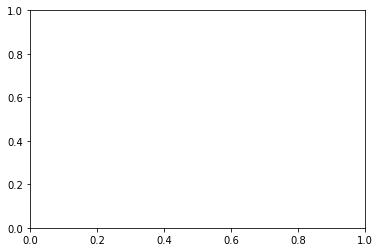

In [149]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
#color = iter(cm.rainbow(np.linspace(0, 1, fold)))
epochs = range(1, 11)
for i in range(fold):
  #c = next(color)
  train_acc = hist['val_ae_action_AUC']
  val_acc = hist['val_acc']
  plt.plot(epochs, acc)
  #plt.plot(epochs, acc, c = c)
  plt.xlabel("epochs")
  plt.ylabel("acc")
  plt.legend()
plt.show()
plt.title("validation acc")

acc graph

In [ ]:
for i in range(fold):
  #c = next(color)
  loss = hist['val_action_loss']
  plt.plot(epochs, loss)
  #plt.plot(epochs, loss, c = c)
  plt.xlabel("epochs")
  plt.ylabel("loss")
  plt.legend()
  plt.show()
  plt.title("validation acc")

predict

In [ ]:
'''def predict(model, data, threshold):
    reconstructtions = model(data)
    loss = tf.keras.losses.mae(reconstruction, data)
    return tf.math.less(loss, threshold)
def print_stats(predictions, labels):
    print("Accuracy = {}".format(accuracy_score(labels, predictions)))
    print("Precision = {}".format(precision_score(labels, predictions)))
    print("Recall = {}".format(recall_score(labels, predictions)))'''


In [ ]:
'''pred = predict(autoencoder, test_data, threshold)
print_stat(preds, test_labels)'''